# Predict the probability of default with a classifier

We will train a classifier for each year to examine how time dependent the model is. LendingClub has already removed the obvious bad loans, so the remaining borrowers that default will be the hard-to-classify cases. The remaining data set is imbalanced (about 8%-17% of borrowers default), so we will have to weight the 'bad_loan'==1 class more heavily. Finally, the predicted probability of default is too high, so we will have to calibrate the classifier's probability with cross validation.

In [1]:
%pylab inline

from __future__ import division

# Data handling
import numpy as np
import pandas as pd
import pickle

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

import diagnostics as diag

# Processing
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
from sklearn import calibration

# Classification
from sklearn.ensemble import RandomForestClassifier

Populating the interactive namespace from numpy and matplotlib


In [2]:
import imp
imp.reload(diag)

<module 'diagnostics' from 'diagnostics.pyc'>

## Load the cleaned data and split it by year

In [6]:
df = pd.read_csv('loan_clean.csv', low_memory=False)
print df['issue_d'].min(), df['issue_d'].max()

2007-06-01 2015-12-01


In [7]:
mask_2007 = (df['issue_d']>='2007-01-01') & (df['issue_d']<'2008-01-01')
mask_2008 = (df['issue_d']>='2008-01-01') & (df['issue_d']<'2009-01-01')
mask_2009 = (df['issue_d']>='2009-01-01') & (df['issue_d']<'2010-01-01')
mask_2010 = (df['issue_d']>='2010-01-01') & (df['issue_d']<'2011-01-01')
mask_2011 = (df['issue_d']>='2011-01-01') & (df['issue_d']<'2012-01-01')
mask_2012 = (df['issue_d']>='2012-01-01') & (df['issue_d']<'2013-01-01')
mask_2013 = (df['issue_d']>='2013-01-01') & (df['issue_d']<'2014-01-01')
mask_2014 = (df['issue_d']>='2014-01-01') & (df['issue_d']<'2015-01-01')
mask_2015 = (df['issue_d']>='2015-01-01') & (df['issue_d']<'2016-01-01')

df_2007 = df[mask_2007]
df_2008 = df[mask_2008]
df_2009 = df[mask_2009]
df_2010 = df[mask_2010]
df_2011 = df[mask_2011]
df_2012 = df[mask_2012]
df_2013 = df[mask_2013]
df_2014 = df[mask_2014]
df_2015 = df[mask_2015]

df_list = [df_2007, df_2008, df_2009, df_2010, df_2011, 
           df_2012, df_2013, df_2014, df_2015]

print 'Number of loans issued each year:'
[len(df['bad_loan']) for df in df_list]

Number of loans issued each year:


[251, 1562, 4716, 8466, 14101, 43332, 55681, 50447, 18102]

## Construct a classifier for 'bad_loan' with a calibrated probability
Performs the following steps:
 - Train-test set split
 - Feature scaling
 - Initialize RandomForestClassifier with selected hyperparameters
 - Do classification and probability calibration on the training set using cross validation
 - Evaluate the model on the training and test sets with a variety of metrics

In [8]:
def train_default_model(df, calibrate=True):
    """Construct a model that predicts borrowers that will default.
    
    Parameters
    ----------
    df : DataFrame of cleaned data
    calibrate : bool
        True if you want to calibrate the clf.predict_proba(X) method using CalibratedClassifierCV()
        
    Returns
    -------
    model : dictionary
        The calibrated classifier and associated information about its performance
    """
    ############## Extract and condition data ##############
    y = df['bad_loan'].values
    X = df.drop(['bad_loan', 'issue_d','total_rec_prncp', 'total_rec_int'], axis=1).values
    
    # Train-test split
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=0.2, random_state=0)
    
    # Mean/standard-deviation scaling.
    # Only use the training set for the scaling. 
    scaler = preprocessing.StandardScaler()
    scaler.fit(X_train)
    
    # Perform feature scaling
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    ############### Initialize (but don't train) random forest ###########
    n_est = 100
    max_depth = 8
    min_leaf = 200
    min_samples_split = 2
    clf = RandomForestClassifier(
        n_estimators=n_est, max_depth=max_depth, 
        min_samples_leaf=min_leaf, min_samples_split=min_samples_split, 
        max_features='sqrt', class_weight='balanced', 
        n_jobs=-1, random_state=1)

    ############ Train and calibrate the classifier using cross validation #######
    if calibrate==True:
        cal_clf = calibration.CalibratedClassifierCV(clf, cv=10, method='sigmoid')
        cal_clf.fit(X_train, y_train)
    else:
        cal_clf = clf
        cal_clf.fit(X_train, y_train)
        
    # Evaluate model on train and test set
    metrics_train = diag.classifier_metrics(cal_clf, X_train, y_train)
    metrics_test = diag.classifier_metrics(cal_clf, X_test, y_test)
    
    return {'X_train':X_train, 'X_test':X_test, 
            'y_train':y_train, 'y_test':y_test,
            'scaler':scaler, 'cal_clf':cal_clf, 
            'metrics_train':metrics_train, 'metrics_test':metrics_test}

## Comparing an uncalibrated classifier to a calibrated classifier

Training-set metrics:
{'acc': 0.60435597865281987, 'P': 0.20116309807031457, 'R': 0.65168058231642045, 'fp': 12088, 'fn': 1627, 'auroc': 0.6723420185357275, 'F1': 0.3074281674493764, 'tn': 17906, 'FPR': 0, 'tp': 3044}
Test-set metrics:
{'acc': 0.59351563401407637, 'P': 0.18733368813198509, 'R': 0.60017050298380226, 'fp': 3054, 'fn': 469, 'auroc': 0.63802607872032213, 'F1': 0.28554045832488334, 'tn': 4440, 'FPR': 0, 'tp': 704}


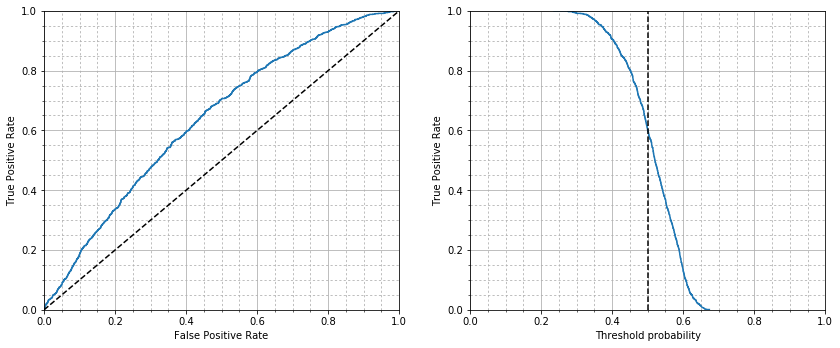

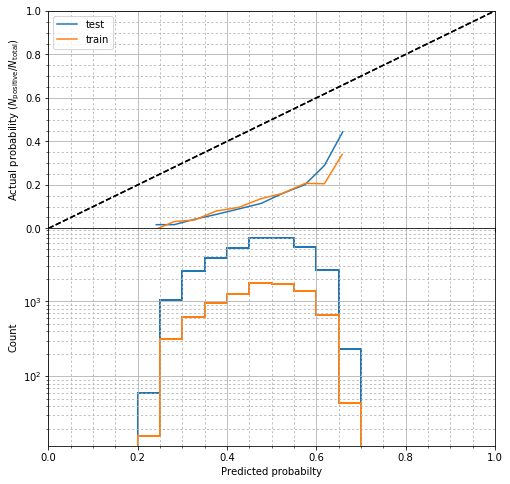

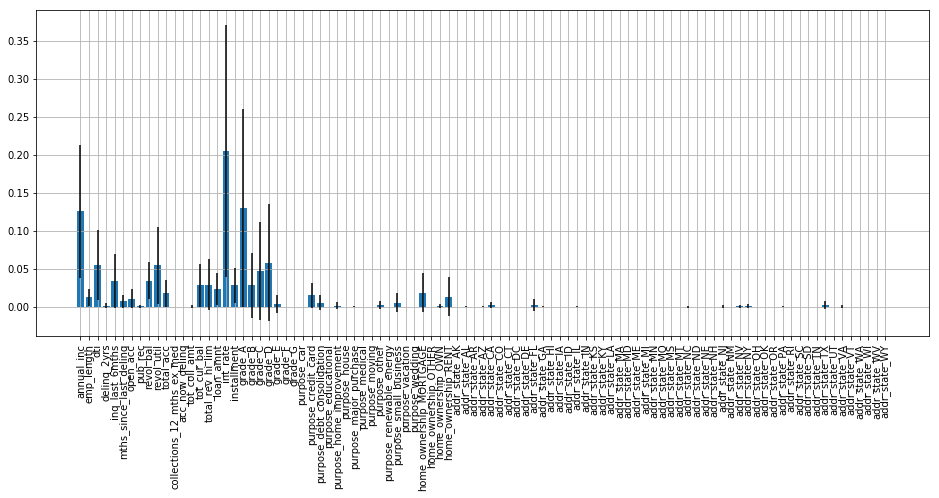

In [12]:
model = train_default_model(df_2012, calibrate=False)

print 'Training-set metrics:'
print model['metrics_train']
print 'Test-set metrics:'
print model['metrics_test']

diag.plot_roc_and_threshold(model['cal_clf'], model['X_test'], model['y_test'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
diag.plot_calibration_curve(fig, ax1, ax2, model['cal_clf'], model['X_train'], model['y_train'], label='test')
diag.plot_calibration_curve(fig, ax1, ax2, model['cal_clf'], model['X_test'], model['y_test'], label='train')

# Determine which features were most important
X_columns = df_2012.drop(['bad_loan', 'issue_d','total_rec_prncp', 'total_rec_int'], axis=1).columns.values
diag.plot_random_forest_feature_importance(model['cal_clf'], X_columns)

Training-set metrics:
{'acc': 0.86525313717005625, 'P': 0.0, 'R': 0.0, 'fp': 0, 'fn': 4671, 'auroc': 0.67162234273729793, 'F1': 0.0, 'tn': 29994, 'FPR': 0, 'tp': 0}
Test-set metrics:
{'acc': 0.86465905157493939, 'P': 0.0, 'R': 0.0, 'fp': 0, 'fn': 1173, 'auroc': 0.63778615958979179, 'F1': 0.0, 'tn': 7494, 'FPR': 0, 'tp': 0}


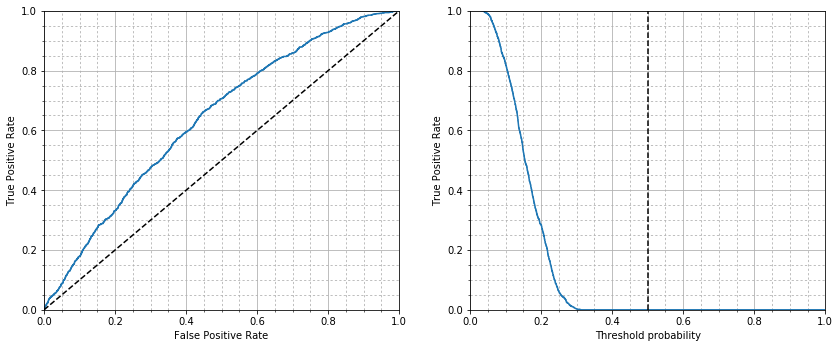

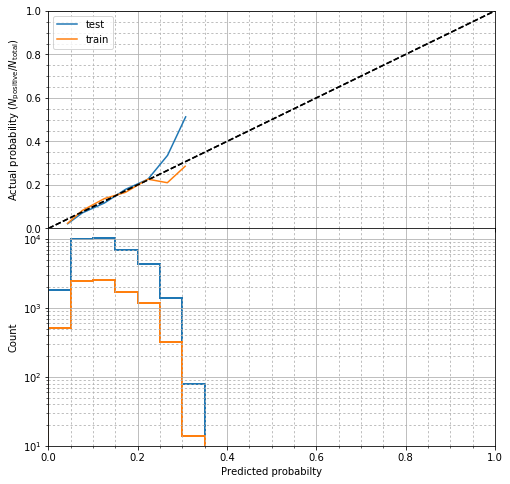

In [13]:
model = train_default_model(df_2012, calibrate=True)

print 'Training-set metrics:'
print model['metrics_train']
print 'Test-set metrics:'
print model['metrics_test']

diag.plot_roc_and_threshold(model['cal_clf'], model['X_test'], model['y_test'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
diag.plot_calibration_curve(fig, ax1, ax2, model['cal_clf'], model['X_train'], model['y_train'], label='test')
diag.plot_calibration_curve(fig, ax1, ax2, model['cal_clf'], model['X_test'], model['y_test'], label='train')

## Construct a separate classifier for each year of data
- Drop 2007, 2008 (too few samples).
- Drop 2014, 2015 (not enough time for 3-year loans to be paid off).

### 2009

{'acc': 0.87486744432661723, 'P': 0.0, 'R': 0.0, 'fp': 0, 'fn': 472, 'auroc': 0.67967321520287616, 'F1': 0.0, 'tn': 3300, 'FPR': 0, 'tp': 0}
{'acc': 0.87076271186440679, 'P': 0.0, 'R': 0.0, 'fp': 0, 'fn': 122, 'auroc': 0.64961509313549515, 'F1': 0.0, 'tn': 822, 'FPR': 0, 'tp': 0}


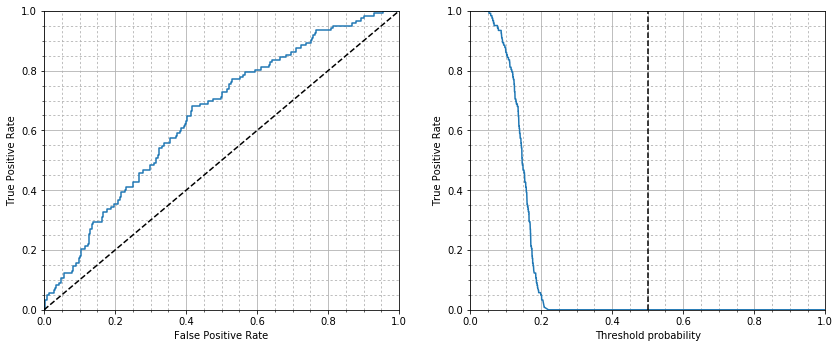

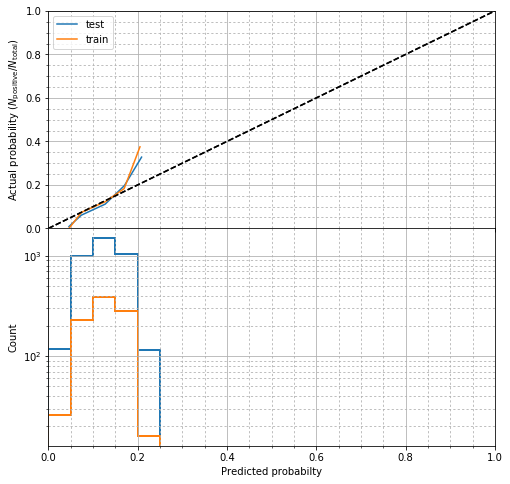

In [12]:
model = train_default_model(df_2009, calibrate=True)

# Pickle the model and all related data
filename = 'model_2009.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)

print model['metrics_train']
print model['metrics_test']

diag.plot_roc_and_threshold(model['cal_clf'], model['X_test'], model['y_test'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
diag.plot_calibration_curve(fig, ax1, ax2, model['cal_clf'], model['X_train'], model['y_train'], label='test')
diag.plot_calibration_curve(fig, ax1, ax2, model['cal_clf'], model['X_test'], model['y_test'], label='train')

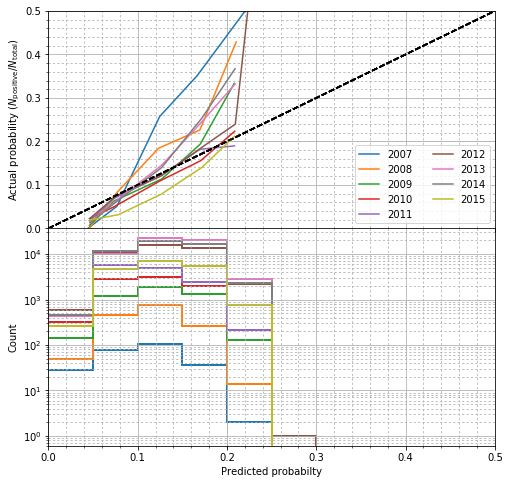

In [13]:
scaler = model['scaler']
cal_clf = model['cal_clf']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
for df, label in zip([df_2007, df_2008, df_2009, df_2010, df_2011, df_2012, df_2013, df_2014, df_2015], 
                    ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015']):
    
    X_true = df.drop(['bad_loan', 'issue_d','total_rec_prncp', 'total_rec_int'], axis=1).values
    X_true = scaler.transform(X_true)
    y_true = df['bad_loan'].values
    diag.plot_calibration_curve(fig, ax1, ax2, cal_clf, X_true, y_true, label=label)
    ax1.legend(ncol=2, loc='lower right')
    ax1.set_xlim(0, 0.5)
    ax1.set_ylim(0, 0.5)

### 2010

{'acc': 0.90283520378027171, 'P': 0.0, 'R': 0.0, 'fp': 0, 'fn': 658, 'auroc': 0.71005505327848883, 'F1': 0.0, 'tn': 6114, 'FPR': 0, 'tp': 0}
{'acc': 0.89138134592680052, 'P': 0.0, 'R': 0.0, 'fp': 0, 'fn': 184, 'auroc': 0.65887921105672331, 'F1': 0.0, 'tn': 1510, 'FPR': 0, 'tp': 0}


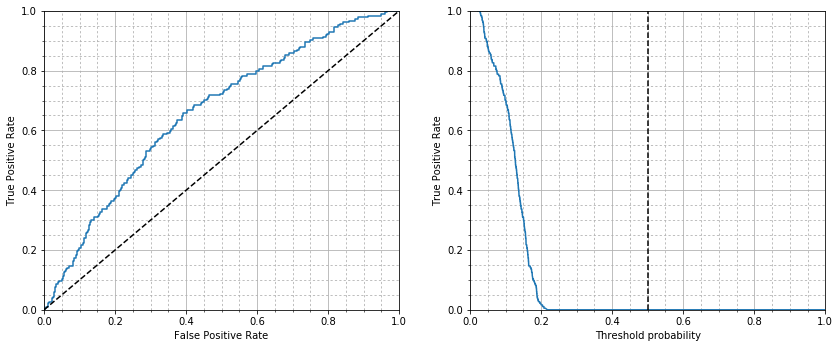

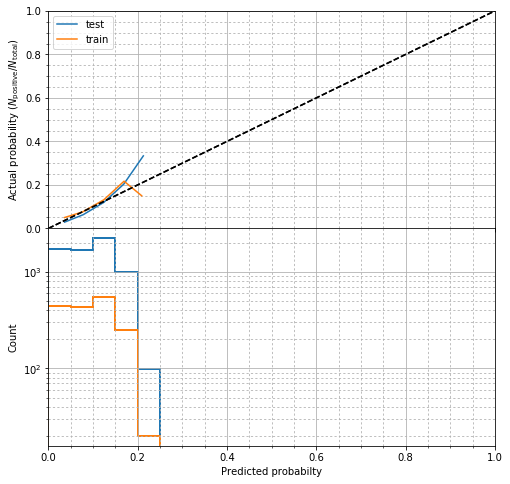

In [14]:
model = train_default_model(df_2010, calibrate=True)

# Pickle the model and all related data
filename = 'model_2010.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)

print model['metrics_train']
print model['metrics_test']

diag.plot_roc_and_threshold(model['cal_clf'], model['X_test'], model['y_test'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
diag.plot_calibration_curve(fig, ax1, ax2, model['cal_clf'], model['X_train'], model['y_train'], label='test')
diag.plot_calibration_curve(fig, ax1, ax2, model['cal_clf'], model['X_test'], model['y_test'], label='train')

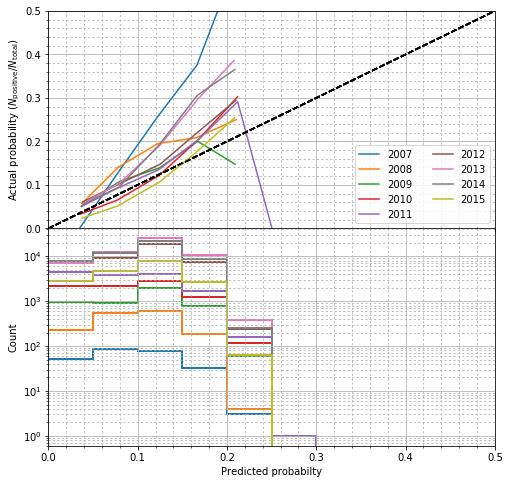

In [15]:
scaler = model['scaler']
cal_clf = model['cal_clf']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
for df, label in zip([df_2007, df_2008, df_2009, df_2010, df_2011, df_2012, df_2013, df_2014, df_2015], 
                    ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015']):
    
    X_true = df.drop(['bad_loan', 'issue_d','total_rec_prncp', 'total_rec_int'], axis=1).values
    X_true = scaler.transform(X_true)
    y_true = df['bad_loan'].values
    diag.plot_calibration_curve(fig, ax1, ax2, cal_clf, X_true, y_true, label=label)
    ax1.legend(ncol=2, loc='lower right')
    ax1.set_xlim(0, 0.5)
    ax1.set_ylim(0, 0.5)

### 2011

{'acc': 0.89494680851063835, 'P': 0.0, 'R': 0.0, 'fp': 0, 'fn': 1185, 'auroc': 0.70155171440931419, 'F1': 0.0, 'tn': 10095, 'FPR': 0, 'tp': 0}
{'acc': 0.88869195320808225, 'P': 0.0, 'R': 0.0, 'fp': 0, 'fn': 314, 'auroc': 0.68599894816805929, 'F1': 0.0, 'tn': 2507, 'FPR': 0, 'tp': 0}


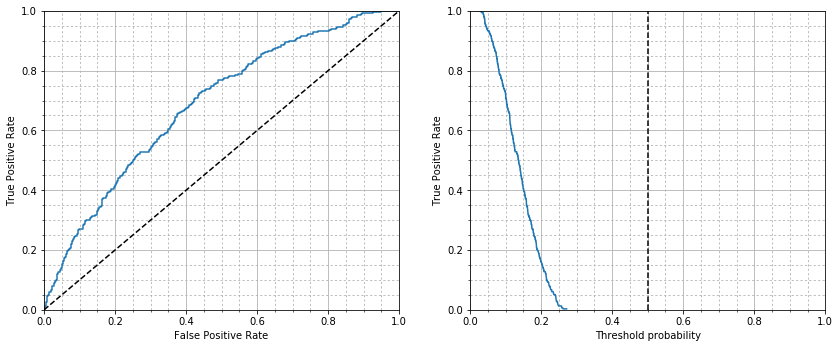

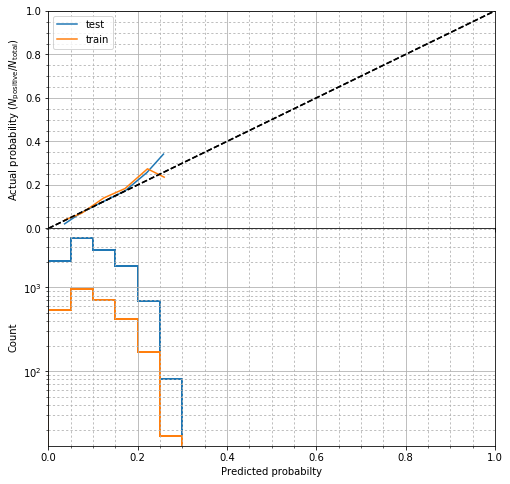

In [16]:
model = train_default_model(df_2011, calibrate=True)

# Pickle the model and all related data
filename = 'model_2011.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)

print model['metrics_train']
print model['metrics_test']

diag.plot_roc_and_threshold(model['cal_clf'], model['X_test'], model['y_test'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
diag.plot_calibration_curve(fig, ax1, ax2, model['cal_clf'], model['X_train'], model['y_train'], label='test')
diag.plot_calibration_curve(fig, ax1, ax2, model['cal_clf'], model['X_test'], model['y_test'], label='train')

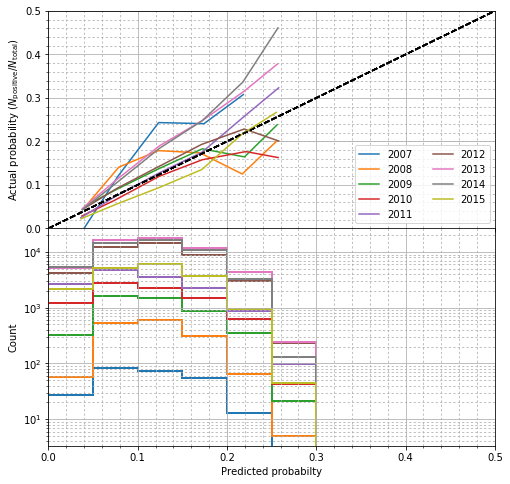

In [17]:
scaler = model['scaler']
cal_clf = model['cal_clf']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
for df, label in zip([df_2007, df_2008, df_2009, df_2010, df_2011, df_2012, df_2013, df_2014, df_2015], 
                    ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015']):
    
    X_true = df.drop(['bad_loan', 'issue_d','total_rec_prncp', 'total_rec_int'], axis=1).values
    X_true = scaler.transform(X_true)
    y_true = df['bad_loan'].values
    diag.plot_calibration_curve(fig, ax1, ax2, cal_clf, X_true, y_true, label=label)
    ax1.legend(ncol=2, loc='lower right')
    ax1.set_xlim(0, 0.5)
    ax1.set_ylim(0, 0.5)

### 2012

{'acc': 0.86525313717005625, 'P': 0.0, 'R': 0.0, 'fp': 0, 'fn': 4671, 'auroc': 0.67162234273729793, 'F1': 0.0, 'tn': 29994, 'FPR': 0, 'tp': 0}
{'acc': 0.86465905157493939, 'P': 0.0, 'R': 0.0, 'fp': 0, 'fn': 1173, 'auroc': 0.63778615958979179, 'F1': 0.0, 'tn': 7494, 'FPR': 0, 'tp': 0}


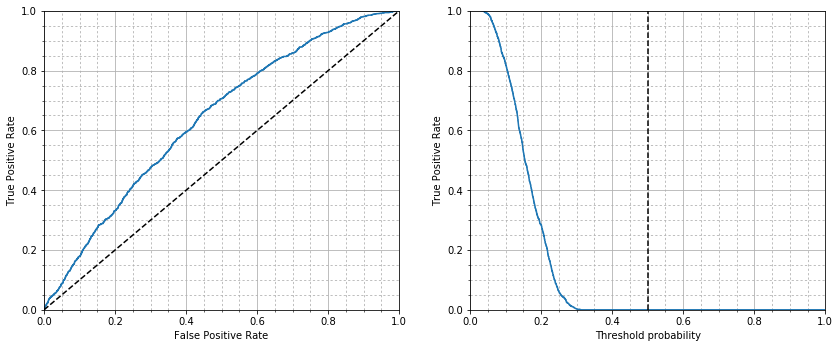

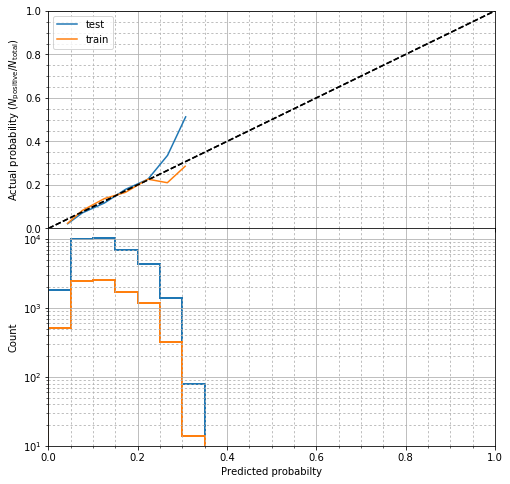

In [18]:
model = train_default_model(df_2012, calibrate=True)

# Pickle the model and all related data
filename = 'model_2012.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)

print model['metrics_train']
print model['metrics_test']

diag.plot_roc_and_threshold(model['cal_clf'], model['X_test'], model['y_test'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
diag.plot_calibration_curve(fig, ax1, ax2, model['cal_clf'], model['X_train'], model['y_train'], label='test')
diag.plot_calibration_curve(fig, ax1, ax2, model['cal_clf'], model['X_test'], model['y_test'], label='train')

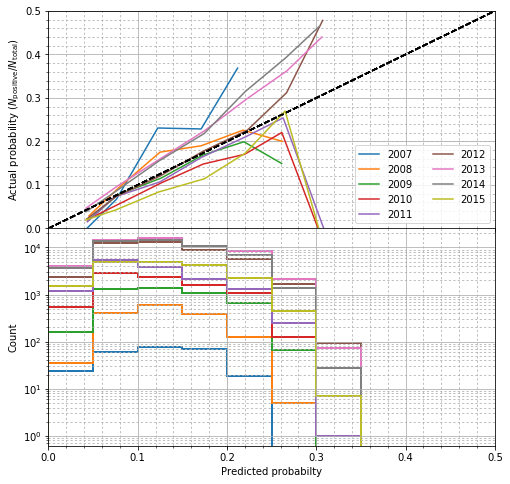

In [19]:
scaler = model['scaler']
cal_clf = model['cal_clf']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
for df, label in zip([df_2007, df_2008, df_2009, df_2010, df_2011, df_2012, df_2013, df_2014, df_2015], 
                    ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015']):
    
    X_true = df.drop(['bad_loan', 'issue_d','total_rec_prncp', 'total_rec_int'], axis=1).values
    X_true = scaler.transform(X_true)
    y_true = df['bad_loan'].values
    diag.plot_calibration_curve(fig, ax1, ax2, cal_clf, X_true, y_true, label=label)
    ax1.legend(ncol=2, loc='lower right')
    ax1.set_xlim(0, 0.5)
    ax1.set_ylim(0, 0.5)

### 2013

{'acc': 0.82199622844827591, 'P': 0.0, 'R': 0.0, 'fp': 0, 'fn': 7929, 'auroc': 0.69289478120779924, 'F1': 0.0, 'tn': 36615, 'FPR': 0, 'tp': 0}
{'acc': 0.82993624854089976, 'P': 0.0, 'R': 0.0, 'fp': 0, 'fn': 1894, 'auroc': 0.69255143393996266, 'F1': 0.0, 'tn': 9243, 'FPR': 0, 'tp': 0}


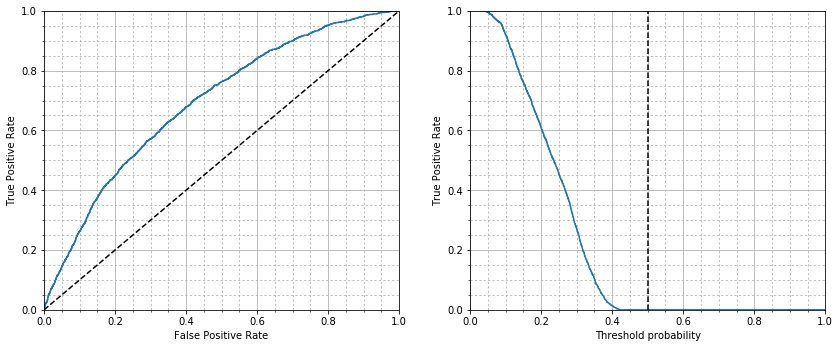

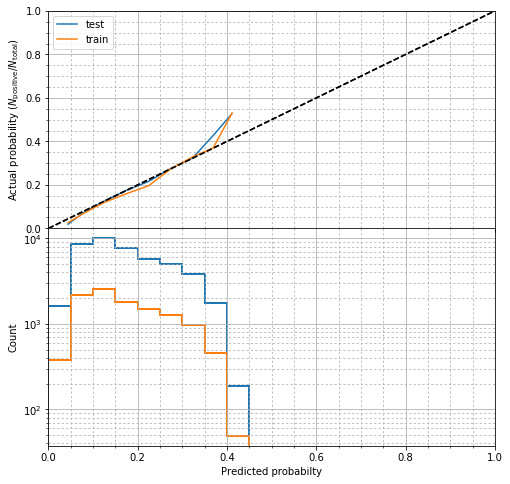

In [20]:
model = train_default_model(df_2013, calibrate=True)

# Pickle the model and all related data
filename = 'model_2013.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)

print model['metrics_train']
print model['metrics_test']

diag.plot_roc_and_threshold(model['cal_clf'], model['X_test'], model['y_test'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
diag.plot_calibration_curve(fig, ax1, ax2, model['cal_clf'], model['X_train'], model['y_train'], label='test')
diag.plot_calibration_curve(fig, ax1, ax2, model['cal_clf'], model['X_test'], model['y_test'], label='train')

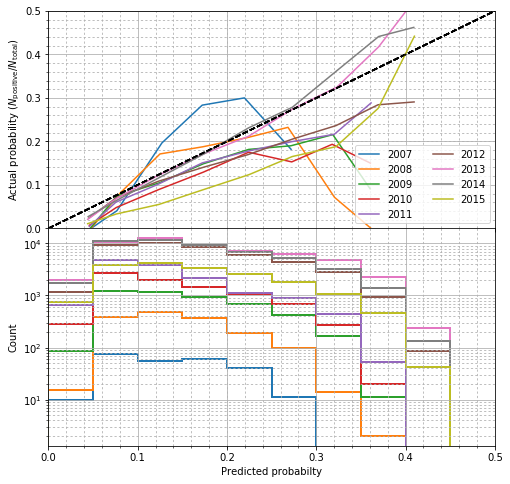

In [21]:
scaler = model['scaler']
cal_clf = model['cal_clf']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
for df, label in zip([df_2007, df_2008, df_2009, df_2010, df_2011, df_2012, df_2013, df_2014, df_2015], 
                    ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015']):
    
    X_true = df.drop(['bad_loan', 'issue_d','total_rec_prncp', 'total_rec_int'], axis=1).values
    X_true = scaler.transform(X_true)
    y_true = df['bad_loan'].values
    diag.plot_calibration_curve(fig, ax1, ax2, cal_clf, X_true, y_true, label=label)
    ax1.legend(ncol=2, loc='lower right')
    ax1.set_xlim(0, 0.5)
    ax1.set_ylim(0, 0.5)

## Conclusions

With a properly calibrated classifier, the predicted probability is never above the standard threshold of 50% used to classify 'bad_loan'==1. This is not surprising since LendingClub has already rejected all the loans they think have a high probability of being charged off.

The data is not stationary. A model trained on one year can be wrong by a factor of about 2 when predicting the probability of default for a loan from another year. This is not necessarily a problem when ranking loans, but is a problem if one wants an accurate assessment of the ROI.